### 完成数据的清洗后，就可以进行分类操作了。
#Remember: Bad data leads to bad models. Always check your data first.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn import svm  
from sklearn.tree import DecisionTreeClassifier 

from sklearn.cross_validation import train_test_split 
from sklearn import metrics 

#### 首先将这批数据的属性和标签分别提取出来。即all_inputs, all_labels

In [3]:
iris_data_clean=pd.read_csv('iris-data-clean.csv')
all_inputs=iris_data_clean[['sepal_length_cm', 'sepal_width_cm',
                             'petal_length_cm', 'petal_width_cm']].values
all_labels=iris_data_clean['Species'].values

labels_num=3
all_labels[0:labels_num]

array(['Iris-setosa', 'Iris-setosa', 'Iris-setosa'], dtype=object)

#### 调用sklearn的train_test_split函数，将数据分为训练集和测试集，这两个集合中都分别有inputs 和 labels

In [4]:
from sklearn.model_selection import train_test_split

(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25, random_state=1)

#### DecisionTreeClassifier
#### 在sklearn.tree 下  import DecisionTreeClassifier

In [5]:
from sklearn.tree import DecisionTreeClassifier

# Create the classifier
decision_tree_classifier = DecisionTreeClassifier()

# Train the classifier on the training set
decision_tree_classifier.fit(training_inputs, training_classes)

# Validate the classifier on the testing set using classification accuracy
decision_tree_classifier.score(testing_inputs, testing_classes)

0.9736842105263158

#### SVM
#### 在sklearn 下 Import svm, 在 svm 下调用 SVM

In [6]:
from sklearn import svm
from sklearn import metrics
model = svm.SVC() #select the algorithm
model.fit(training_inputs,training_classes) # we train the algorithm with the training data and the training output
prediction=model.predict(testing_inputs) #now we pass the testing data to the trained algorithm
print('The accuracy of the SVM is:',metrics.accuracy_score(prediction,testing_classes))#now we check the accuracy of the algorithm. 

The accuracy of the SVM is: 1.0


#### LogisticRegression
#### 在sklearn.linear_model 下 import LogisticRegression

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
model = LogisticRegression()
model.fit(training_inputs,training_classes)
prediction=model.predict(testing_inputs)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction,testing_classes))

The accuracy of the Logistic Regression is 0.9473684210526315


#### KNN
#### 在sklearn.neighbors 下 import KNeighborsClassifier

In [8]:
from sklearn.neighbors import KNeighborsClassifier
model=KNeighborsClassifier(n_neighbors=3) #this examines 3 neighbours for putting the new data into a class
model.fit(training_inputs,training_classes)
prediction=model.predict(testing_inputs)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction,testing_classes))

The accuracy of the KNN is 0.9736842105263158


# .
## 以上只是简单的调用了sklearn中的模型，接下来具体对DecisionTree做进一步分析：

Heck yeah! Our model achieves 97% classification accuracy without much effort.

However, there's a catch: Depending on how our training and testing set was sampled, our model can achieve anywhere from 80% to 100% accuracy:
#准确率波动太大

''

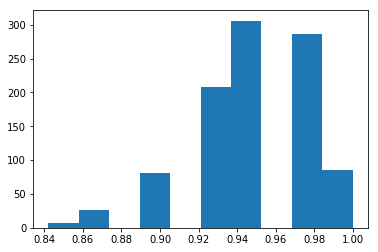

In [9]:
model_accuracies = []

for repetition in range(1000):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier()
    decision_tree_classifier.fit(training_inputs, training_classes)
    classifier_accuracy = decision_tree_classifier.score(testing_inputs, testing_classes)
    
    model_accuracies.append(classifier_accuracy)
    
plt.hist(model_accuracies)
;

It's obviously a problem that our model performs quite differently depending on the subset of the data it's trained on. This phenomenon is known as overfitting: The model is learning to classify the training set so well that it doesn't generalize and perform well on data it hasn't seen before.

Cross-validation
[ go back to the top ]

This problem is the main reason that most data scientists perform k-fold cross-validation on their models: Split the original data set into k subsets, use one of the subsets as the testing set, and the rest of the subsets are used as the training set. This process is then repeated k times such that each subset is used as the testing set exactly once.

10-fold cross-validation is the most common choice, so let's use that here. Performing 10-fold cross-validation on our data set looks something like this:

(each square is an entry in our data set)

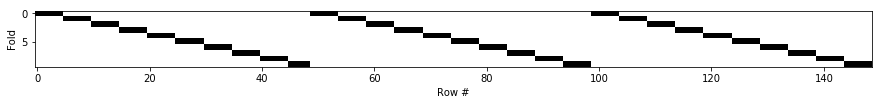

In [10]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

def plot_cv(cv, features, labels):
    masks = []
    for train, test in cv.split(features, labels):
        mask = np.zeros(len(labels), dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none', cmap='gray_r')
    plt.ylabel('Fold')
    plt.xlabel('Row #')

plot_cv(StratifiedKFold(n_splits=10), all_inputs, all_labels)

You'll notice that we used Stratified k-fold cross-validation in the code above. Stratified k-fold keeps the class proportions the same across all of the folds, which is vital for maintaining a representative subset of our data set. (e.g., so we don't have 100% Iris setosa entries in one of the folds.)您会注意到，我们在上面的代码中使用了分层的k-fold交叉验证。分层k-fold在所有折叠中保持类的比例相同，这对于维护数据集的代表性子集是至关重要的。

We can perform 10-fold cross-validation on our model with the following code:

''

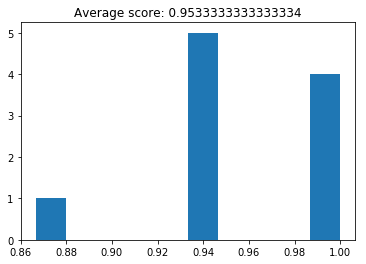

In [11]:
from sklearn.model_selection import cross_val_score

decision_tree_classifier = DecisionTreeClassifier()

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

#### Now we have a much more consistent rating of our classifier's general classification accuracy.

### Parameter tuning

Every Machine Learning model comes with a variety of parameters to tune, and these parameters can be vitally important to the performance of our classifier. For example, if we severely limit the depth of our decision tree classifier:

''

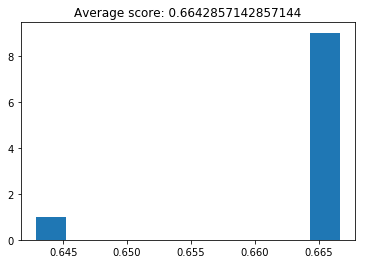

In [12]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=1)

cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10)
plt.hist(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
;

the classification accuracy falls tremendously.

Therefore, we need to find a systematic method to discover the best parameters for our model and data set.

The most common method for model parameter tuning is Grid Search. The idea behind Grid Search is simple: explore a range of parameters and find the best-performing parameter combination. Focus your search on the best range of parameters, then repeat this process several times until the best parameters are discovered.

Let's tune our decision tree classifier. We'll stick to only two parameters for now, but it's possible to simultaneously explore dozens of parameters if we want.

In [13]:
from sklearn.model_selection import GridSearchCV

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9664429530201343
Best parameters: {'max_depth': 3, 'max_features': 3}


Now let's visualize the grid search to see how the parameters interact.

''

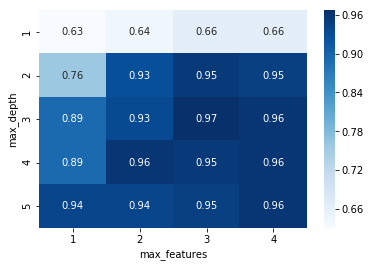

In [14]:
grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (5, 4)
sb.heatmap(grid_visualization, cmap='Blues', annot=True)

plt.xticks(np.arange(4) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(5) + 0.5, grid_search.param_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')
;

Now we have a better sense of the parameter space: We know that we need a max_depth of at least 2 to allow the decision tree to make more than a one-off decision.

max_features doesn't really seem to make a big difference here as long as we have 2 of them, which makes sense since our data set has only 4 features and is relatively easy to classify. (Remember, one of our data set's classes was easily separable from the rest based on a single feature.)

Let's go ahead and use a broad grid search to find the best settings for a handful of parameters.

In [15]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                  'max_depth': [1, 2, 3, 4, 5],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9664429530201343
Best parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 2, 'splitter': 'best'}


In [16]:
decision_tree_classifier = grid_search.best_estimator_
decision_tree_classifier

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [17]:
import sklearn.tree as tree
from sklearn.externals.six import StringIO

with open('iris_dtc.dot', 'w') as out_file:
    out_file = tree.export_graphviz(decision_tree_classifier, out_file=out_file)

''

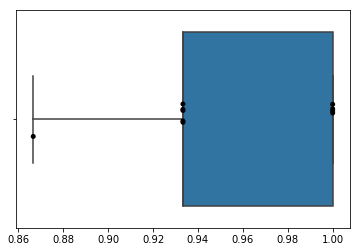

In [18]:
dt_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10)

sb.boxplot(dt_scores)
sb.stripplot(dt_scores, jitter=True, color='black')
;

Hmmm... that's a little boring by itself though. How about we compare another classifier to see how they perform?

We already know from previous projects that Random Forest classifiers usually work better than individual decision trees. A common problem that decision trees face is that they're prone to overfitting: They complexify to the point that they classify the training set near-perfectly, but fail to generalize to data they have not seen before.

Random Forest classifiers work around that limitation by creating a whole bunch of decision trees (hence "forest") — each trained on random subsets of training samples (drawn with replacement) and features (drawn without replacement) — and have the decision trees work together to make a more accurate classification.

Let that be a lesson for us: Even in Machine Learning, we get better results when we work together!

Let's see if a Random Forest classifier works better here.

The great part about scikit-learn is that the training, testing, parameter tuning, etc. process is the same for all models, so we only need to plug in the new classifier.

In [19]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()

parameter_grid = {'n_estimators': [10, 25, 50, 100],
                  'criterion': ['gini', 'entropy'],
                  'max_features': [1, 2, 3, 4]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(random_forest_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.9664429530201343
Best parameters: {'criterion': 'gini', 'max_features': 3, 'n_estimators': 50}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

''

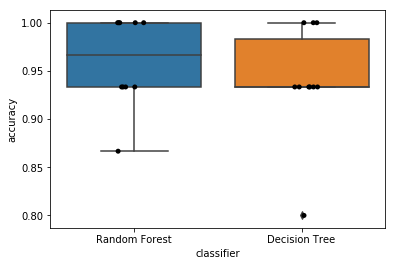

In [20]:
random_forest_classifier = grid_search.best_estimator_

rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, all_inputs, all_labels, cv=10),
                       'classifier': ['Random Forest'] * 10})
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=10),
                      'classifier': ['Decision Tree'] * 10})
both_df = rf_df.append(dt_df)

sb.boxplot(x='classifier', y='accuracy', data=both_df)
sb.stripplot(x='classifier', y='accuracy', data=both_df, jitter=True, color='black')
;